Preamble

My goal with this work is not to succed or make something better, but to learn how to use graph based representations

# Deep Q Network (DQN)

This notebook is to create an agent that works using Deep Q Network (DQN) over the generic Q Learning approach.

<!-- For submission check https://www.kaggle.com/aithammadiabdellatif/lux-submission -->
## Q Learning

Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.

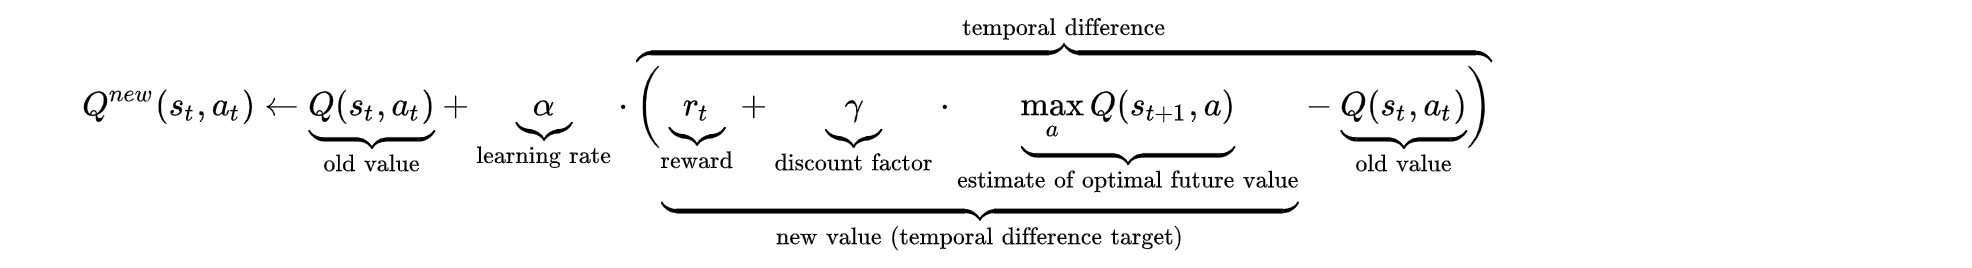

![](https://github.com/aaiit/lux/raw/main/lux.png)

In [1]:
!pip install git+https://github.com/aimat-lab/gcnn_keras 
!pip install -q kaggle-environments -U
!cp -r ../input/lux-ai-2021/* .
!git clone https://github.com/aaiit/lux-AI.git

  Cloning https://github.com/aimat-lab/gcnn_keras to /tmp/pip-req-build-fvib8a3y
  Running command git clone -q https://github.com/aimat-lab/gcnn_keras /tmp/pip-req-build-fvib8a3y
  Created wheel for kgcnn: filename=kgcnn-1.1.2-py3-none-any.whl size=189376 sha256=134a0df5028eab0a37f582210a68223aa0c39749187ba801d0ccf05b250a9247
  Stored in directory: /tmp/pip-ephem-wheel-cache-wzxhfa1a/wheels/ec/d3/77/8978ee5adcc8fea00965b692f28c2b9c5912614086ae931bc8
Successfully built kgcnn
Cloning into 'lux-AI'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 141 (delta 42), reused 62 (delta 8), pack-reused 0
Receiving objects: 100% (141/141), 1.23 MiB | 2.97 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [2]:
!cp lux-AI/Game/*.py . 
!cp lux-AI/Game/lux/* lux/ 
!cp lux-AI/*.png .

In [3]:
!python3 -c 'import kgcnn as tf; print(tf.__version__)'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
AttributeError: module 'kgcnn' has no attribute '__version__'


<!-- Steps involved in reinforcement learning using deep Q-learning networks (DQNs):

1. All the past experience is stored by the user in memory
2. The next action is determined by the maximum output of the Q-network
3. The loss function here is mean squared error of the predicted Q-value and the target Q-value – Q*. This is basically a regression problem. However, we do not know the target or actual value here as we are dealing with a reinforcement learning problem. Going back to the Q-value update equation derived fromthe Bellman equation. we have: -->

In [4]:
from kgcnn.layers.gather import GatherNodes
from kgcnn.layers.keras import Dense, LazyConcatenate  # ragged support
from kgcnn.layers.pooling import PoolingLocalMessages, PoolingNodes

from kaggle_environments import make
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.game_objects import Unit
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math, sys
import numpy as np
import random
from IPython.display import clear_output 
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_hub as hub
from collections import deque


Loading environment football failed: No module named 'gfootball'


# The input of the model 

In [5]:
TYPE_DICT = {None:0, Constants.RESOURCE_TYPES.WOOD: 1, Constants.RESOURCE_TYPES.COAL: 2, Constants.RESOURCE_TYPES.URANIUM: 3 }
def jitter(n):

    adjencent = []# np.zeros((32,32))
    for x in range(n**2):
            
        row = x // n
        col = x % n
        if col < n-1:
            adjencent.append((x, row*n+col+1))
            adjencent.append((row*n+col+1, x)) #symetry
        if row < n-1:
            adjencent.append((x, (row+1)*n+col))
            adjencent.append(((row+1)*n+col, x))
       
    return adjencent
def get_inputs(game_state):
    w,h = game_state.map.width, game_state.map.height
    # Nodelist(Map Tile)
    # Format: Resource Type, Number Resources
    NG = np.zeros((1,w*h,2))

    #NG = [[None]*w for i in range(h)]

    for i in range(w):
        for j in range(h):
            cell = game_state.map.map[j][i]
            node_id = j*h+i
            if cell.resource is None:
                if cell.citytile is None:
                    NG[0][node_id] = [0, 0]#blank
                else:
                    NG[0][node_id] = [4, 0] #city
            else:
                NG[0][node_id] = [TYPE_DICT[cell.resource.type], cell.resource.amount]
            #NG = [[ 0 if game_state.map.map[j][i].resource==None elif game_state.map.map[j][i].citytile is None TYPE_DICT[game_state.map.map[j][i].resource.type] else 4]]
            #NG[i*h+w,1] = 0 if game_state.map.map[j][i].resource==None else game_state.map.map[j][i].resource.amount
            
    #NG = tf.data.Dataset.from_tensors(NG)#, 'node_input'
    #edge_list = tf.data.Dataset.from_tensor_slices(np.array(jitter(3)).reshape(1,-1,2))#, 'edge_index_input'
    NG = tf.ragged.constant(NG, ragged_rank=1, inner_shape=(2, ))
    
    edge_list = np.array(jitter(w)).reshape(1,-1,2)
    edge_list = tf.ragged.constant(edge_list, ragged_rank=1, inner_shape=(2, ))
    
    # The map of units features
    U_player = [ [[0,0,0,0,0] for i in range(w)]  for j in range(h)]    
    units = game_state.player.units
    for i in units:
        U_player[i.pos.y][i.pos.x] = [i.type,i.cooldown,i.cargo.wood,i.cargo.coal,i.cargo.uranium]
    U_player = np.array(U_player)#
    
    U_opponent = [ [[0,0,0,0,0] for i in range(w)]  for j in range(h)]
    units = game_state.opponent.units
    for i in units:
        U_opponent[i.pos.y][i.pos.x] = [i.type,i.cooldown,i.cargo.wood,i.cargo.coal,i.cargo.uranium]

    U_opponent = np.array(U_opponent)
    
    # The map of cities featrues
    e = game_state.player.cities
    C_player = [ [[0,0,0] for i in range(w)]  for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C_player[i.pos.y][i.pos.x] = [i.cooldown,e[k].fuel,e[k].light_upkeep]
    C_player = np.array(C_player)

    e = game_state.opponent.cities
    C_opponent = [ [[0,0,0] for i in range(w)]  for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C_opponent[i.pos.y][i.pos.x] = [i.cooldown,e[k].fuel,e[k].light_upkeep]
    C_opponent = np.array(C_opponent)
    
    # stacking all in one array
    #E = tf.data.Dataset.from_tensors(np.dstack([U_opponent,U_player,C_opponent,C_player]))
    E= tf.expand_dims(np.dstack([U_opponent,U_player,C_opponent,C_player]), axis=0).numpy()
    return [NG, edge_list,E]
    #return tf.data.Dataset.zip(( NG, edge_list,E))#.map(lambda _map, n, e: {'The game map': _map, 'node_input': n, 'edge_index_input': e}).as_numpy_iterator().batch(265)
    #return E, NG, edge_list
    


# Model

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_hub as hub
from collections import deque
import random
import math
from tensorflow.keras import backend as K

"""
we add two lines:

e= tf.keras.backend.max(y_true,axis = -1)
y_pred*= K.stack([e]*8, axis=-1)
    
to make the positions which doesn't contain neither unit or city by zero in the prediction probabilities, in order to focus only on the main occupied positions.
"""

def custom_mean_squared_error(y_true, y_pred):
    y_units_true = y_true[:,:,:,:6]
    y_cities_true = y_true[:,:,:,6:]

    y_units_pred = y_pred[:,:,:,:6]
    y_cities_pred = y_pred[:,:,:,6:]
    
    
    is_unit = tf.keras.backend.max(y_units_true,axis = -1)
    is_city = tf.keras.backend.max(y_cities_true,axis = -1)
    
    y_units_pred*= K.stack([is_unit]*6, axis=-1)
    y_cities_pred*= K.stack([is_city]*2, axis=-1)
    
    loss1 = K.square(y_units_pred - y_units_true)#/K.sum(is_unit)
    loss2 = K.square(y_cities_pred - y_cities_true)#/K.sum(is_city)
    return K.concatenate([loss1,loss2])

def units_accuracy(y_true, y_pred):
    y_units_true = y_true[:,:,:,:6]
    y_cities_true = y_true[:,:,:,6:]

    y_units_pred = y_pred[:,:,:,:6]
    y_cities_pred = y_pred[:,:,:,6:]
    
    is_unit = tf.keras.backend.max(y_units_true,axis = -1)
    y_units_pred*= K.stack([is_unit]*6, axis=-1)
    return K.cast(K.equal(y_units_true, K.round(y_units_pred)), "float32")/K.sum(is_unit)

def cities_accuracy(y_true, y_pred):
    y_units_true = y_true[:,:,:,:6]
    y_cities_true = y_true[:,:,:,6:]

    y_units_pred = y_pred[:,:,:,:6]
    y_cities_pred = y_pred[:,:,:,6:]
    
    is_city = tf.keras.backend.max(y_cities_true,axis = -1)
    y_cities_pred*= K.stack([is_city]*2, axis=-1)
    
    return K.cast(K.equal(y_cities_true, K.round(y_cities_pred)), "float32")/K.sum(is_city)


def get_model(s):
    
    #shape 4(n**2+n), 0 if 1

    
    n = keras.Input(shape=(None, 2), name='node_input', dtype="float32", ragged=True)
    
    ei = keras.Input(shape=(None, 2), name='edge_index_input', dtype="int64", ragged=True)
    n_in_out = GatherNodes()([n, ei])
    node_messages = Dense(4, activation='relu')(n_in_out)
    node_updates = PoolingLocalMessages()([n, node_messages, ei])
    n_node_updates = LazyConcatenate(axis=-1)([n, node_updates])
    
    n_embedd = Dense(s**2)(n_node_updates)#s**2
    #n_embedd = layers.Reshape((s,s,-1))(n_embedd)
    g_embedd = PoolingNodes()(n_embedd)
    #print(g_embedd.shape)
    
    inputs = keras.Input(shape=(s,s,16),name = 'The game map')#,name = 'The game map'
    #f = layers.Flatten()(inputs)   
    h,w= s,s
    f = layers.Conv2D(16, (4,4), padding='same')(inputs)
    f = layers.Flatten()(f)
    #f = layers.Conv1D(4, (4,4), padding='same')(f)
    f = layers.Dense(w*h,activation = "sigmoid")(f)
    f = layers.Reshape((h,w,-1))(f)
    combined = layers.Concatenate()([f, layers.Reshape((h,w,-1))(g_embedd)])#layers.Reshape((h,w,-1))(g_embedd)#
    #cov_combined = layers.Conv2D(4, 2, activation='relu', data_format='channels_last')(combined)
    #cov_combined = layers.Dense(1)(combined)
    units = layers.Dense(6,activation = "softmax",name = "Units_actions")(combined)#,name = "Units_actions"
    cities = layers.Dense(2,activation = "sigmoid",name = "Cities_actions")(combined)#,name = "Cities_actions"
    output = layers.Concatenate()([units,cities])
    model = keras.Model(inputs = [n, ei, inputs], outputs = output)
    #model = keras.Model(inputs = inputs, outputs = output)
    model.compile(optimizer= "adam", loss= custom_mean_squared_error ,metrics = ["accuracy"])
    
    return model


model =get_model(12)
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
edge_index_input (InputLayer)   [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
gather_embedding_24 (GatherEmbe (None, None, 4)      0           node_input[0][0]                 
                                                                 edge_index_input[0][0]           
__________________________________________________________________________________________________
dense_112 (Dense)               (None, None, 4)      20          gather_embedding_24[0][0] 

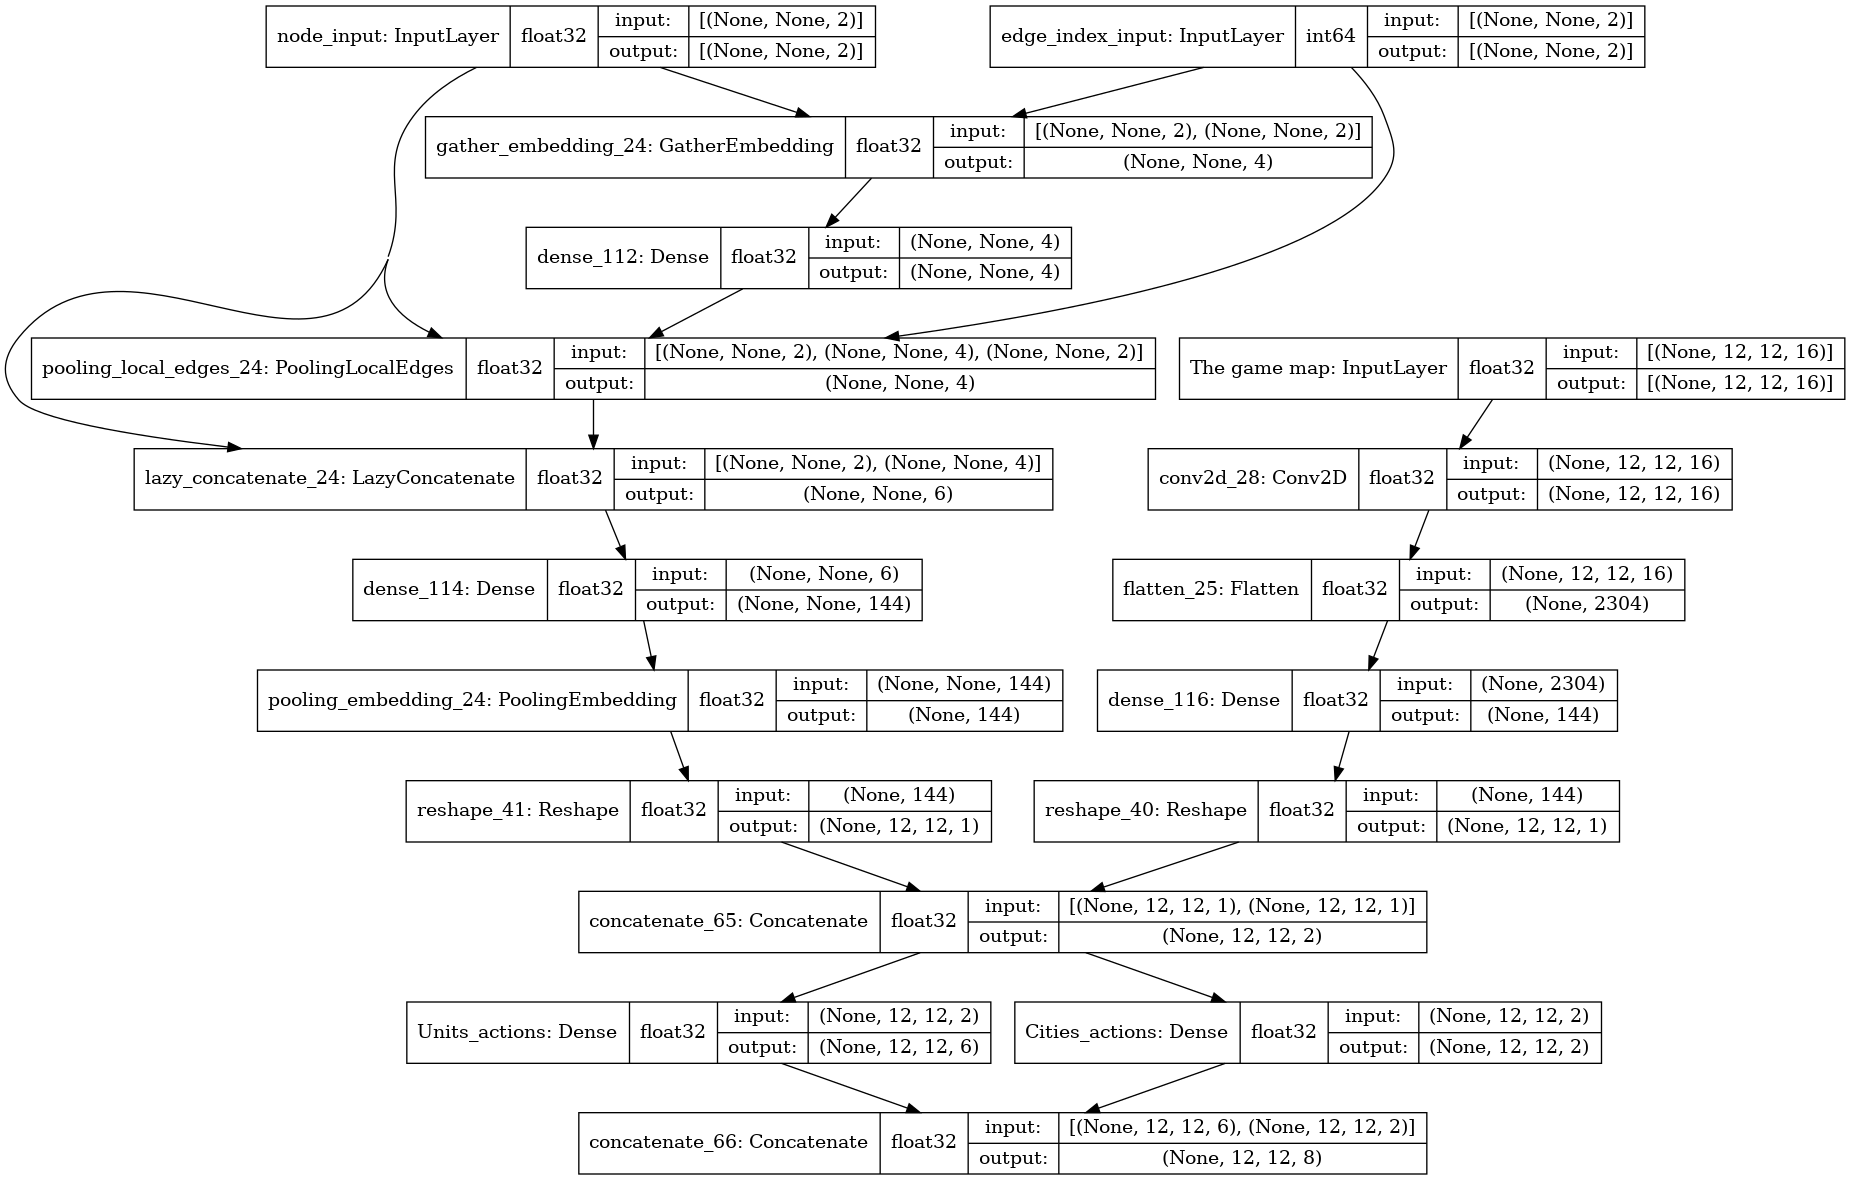

In [44]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=1,
    show_dtype=1,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [45]:
import tensorflow.keras as ks

from kgcnn.layers.casting import ChangeTensorType
from kgcnn.layers.gather import GatherNodesOutgoing
from kgcnn.layers.keras import Dense, Activation, LazyAdd
from kgcnn.layers.mlp import MLP
from kgcnn.layers.pooling import PoolingNodes, PoolingLocalEdges
from kgcnn.layers.pool.topk import PoolingTopK, UnPoolingTopK, AdjacencyPower
from kgcnn.utils.models import generate_embedding, update_model_kwargs

# Graph U-Nets
# by Hongyang Gao, Shuiwang Ji
# https://arxiv.org/pdf/1905.05178.pdf

model_default = {'name': "Unet",
                 'inputs': [{'shape': (None,), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None,), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
                 'input_embedding': {"node": {"input_dim": 95, "output_dim": 64},
                                     "edge": {"input_dim": 5, "output_dim": 64}},
                 'output_embedding': 'graph',
                 'output_units': {"use_bias": [True, False], "units": [25, 6], "activation": ['relu', 'softmax']}, #unit
                 'output_citys': {"use_bias": [True, False], "units": [25, 2], "activation": ['relu', 'sigmoid']},
                 'hidden_dim': {'units': 32, 'use_bias': True, 'activation': 'linear'},
                 'top_k_args': {'k': 0.3, 'kernel_initializer': 'ones'},
                 'activation': 'relu',
                 'use_reconnect': True,
                 'depth': 4,
                 'pooling_args': {"pooling_method": 'segment_mean'},
                 'gather_args': {"node_indexing": 'sample'},
                 'verbose': 1
                 }


@update_model_kwargs(model_default)
def make_model(inputs=None,
               input_embedding=None,
               output_embedding=None,
               output_units=None,
               output_citys=None,
               pooling_args=None,
               gather_args=None,
               top_k_args=None,
               depth=None,
               use_reconnect=None,
               hidden_dim=None,
               activation=None, **kwargs):
    r"""Make U-Net graph network via functional API. Default parameters can be found in :obj:`model_default`.

    Args:
        inputs (list): List of dictionaries unpacked in :obj:`tf.keras.layers.Input`. Order must match model definition.
        input_embedding (dict): Dictionary of embedding arguments for nodes etc. unpacked in `Embedding` layers.
        output_embedding (str): Main embedding task for graph network. Either "node", ("edge") or "graph".
        output_mlp (dict): Dictionary of layer arguments unpacked in the final classification `MLP` layer block.
            Defines number of model outputs and activation.
        depth (int): Number of graph embedding units or depth of the network.
        pooling_args (dict): Dictionary of layer arguments unpacked in `PoolingLocalEdges` layers.
        gather_args (dict): Dictionary of layer arguments unpacked in `GatherNodesOutgoing` layers.
        top_k_args (dict): Dictionary of layer arguments unpacked in `PoolingTopK` layers.
        use_reconnect (bool): Whether to use :math:`A^2` between pooling.
        hidden_dim (dict): Dictionary of layer arguments unpacked in hidden `Dense` layer.
        activation (dict, str): Activation to use.

    Returns:
        tf.keras.models.Model
    """

    # Make input
    node_input = ks.layers.Input(**inputs[0])
    edge_input = ks.layers.Input(**inputs[1])
    edge_index_input = ks.layers.Input(**inputs[2])

    # embedding, if no feature dimension
    n = generate_embedding(node_input, inputs[0]['shape'], input_embedding['node'])
    ed = generate_embedding(edge_input, inputs[1]['shape'], input_embedding['edge'])
    edi = edge_index_input

    # Model
    n = Dense(**hidden_dim)(n)
    in_graph = [n, ed, edi]
    graph_list = [in_graph]
    map_list = []

    # U Down
    i_graph = in_graph
    for i in range(0, depth):

        n, ed, edi = i_graph
        # GCN layer
        eu = GatherNodesOutgoing(**gather_args)([n, edi])
        eu = Dense(**hidden_dim)(eu)
        nu = PoolingLocalEdges(**pooling_args)([n, eu, edi])  # Summing for each node connection
        n = Activation(activation=activation)(nu)

        if use_reconnect:
            ed, edi = AdjacencyPower(n=2)([n, ed, edi])

        # Pooling
        i_graph, i_map = PoolingTopK(**top_k_args)([n, ed, edi])

        graph_list.append(i_graph)
        map_list.append(i_map)

    # U Up
    ui_graph = i_graph
    for i in range(depth, 0, -1):
        o_graph = graph_list[i - 1]
        i_map = map_list[i - 1]
        ui_graph = UnPoolingTopK()(o_graph + i_map + ui_graph)

        n, ed, edi = ui_graph
        # skip connection
        n = LazyAdd()([n, o_graph[0]])
        # GCN
        eu = GatherNodesOutgoing(**gather_args)([n, edi])
        eu = Dense(**hidden_dim)(eu)
        nu = PoolingLocalEdges(**pooling_args)([n, eu, edi])  # Summing for each node connection
        n = Activation(activation=activation)(nu)

        ui_graph = [n, ed, edi]

    # Output embedding choice
    n = ui_graph[0]
    if output_embedding == 'graph':
        out = PoolingNodes(**pooling_args)(n)
        out = MLP(**output_mlp)(out)
        main_output = ks.layers.Flatten()(out)  # will be dense
    elif output_embedding == 'node':
        out_unit = MLP(**output_units)(n)
        unit_output = ChangeTensorType(input_tensor_type='ragged', output_tensor_type="tensor")(out_unit)
        out_city = MLP(**output_citys)(n)
        city_output = ChangeTensorType(input_tensor_type='ragged', output_tensor_type="tensor")(out_city)
        main_output = layers.Concatenate()([out_unit,out_city])
    else:
        raise ValueError("Unsupported graph embedding for mode `Unet`")

    model = ks.models.Model(inputs=[node_input, edge_input, edge_index_input], outputs=main_output)
    return model

In [ ]:
tf.keras.utils.plot_model(
    make_model(output_embedding='node'),
    to_file="model.png",
    show_shapes=1,
    show_dtype=1,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [46]:
size = 12
env = make("lux_ai_2021", debug=True, configuration={"annotations": True, "width":size, "height":size})

observation = env.reset()[0]['observation']
if observation["step"] == 0:
    game_state = Game()
    game_state._initialize(observation["updates"])
    game_state._update(observation["updates"][2:])
    game_state.id = observation.player
else:
    game_state._update(observation["updates"])


### AI Code goes down here! ### 
player = game_state.players[observation.player]
opponent = game_state.players[(observation.player + 1) % 2]
width, height = game_state.map.width, game_state.map.height

# Get Prediction of actions
x = get_inputs(game_state)
y = model.predict(x)[0]



The function will take the units of the game stat and predict the options and directions in case of move option gathered in actions list

In [47]:
def get_prediction_actions(y,player):
    # move
    option = np.argmax(y,axis = 2) 
    # c s n w e build_city & research & buid_worker  
    actions = []
    for i in player.units:
#         print(option.shape,i.pos.y,i.pos.x)
        d = "csnwe#############"[option[i.pos.y,i.pos.x]]
        if option[i.pos.y,i.pos.x]<5:actions.append(i.move(d))
        elif option[i.pos.y,i.pos.x]==5 and i.can_build(game_state.map):actions.append(i.build_city())
    
    city_tiles: List[CityTile] = []
    for city in player.cities.values():
        for city_tile in city.citytiles:
#             city_tiles.append(city_tile)
            if option[city_tile.pos.y,city_tile.pos.x]==6:
                action = city_tile.research()
                actions.append(action)
            if option[city_tile.pos.y,city_tile.pos.x]==7:
                action = city_tile.build_worker()
                actions.append(action)
    return actions,option

# RL agent

In [48]:
Last_State = {}
learning_rate = 0.01
gamma = 0.95
epsilon = 1.0
epsilon_final = 0.01
epsilon_decay = 0.995
game_state = None
model = None
last_reward = 0
W = 0
def agent(observation, configuration):
    global game_state,epsilon,model,last_reward,W
    
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
    else:
        game_state._update(observation["updates"])
    

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height

    # Get Prediction of actions
    x = get_inputs(game_state)
    y = model.predict(x)[0]
    
    if random.random()<epsilon:
        y = np.random.rand(*y.shape)
    print("eps ",epsilon,end= " | ") 
    actions,option = get_prediction_actions(y,player)
    if observation["reward"]>100:reward=0
    else:reward=observation["reward"]
    print("Reward",reward)

    
    if observation.player in Last_State:
        _x,_y,_player,_option = Last_State[observation.player]
        state,next_state,reward = _x,x,observation["reward"]
        if reward>1000:reward=0
        # Reward 
        if reward > last_reward:r=1
        elif reward < last_reward:r = -1
        else:r = 0
        
        # Q-learning update

        for i in _player.units:
            Q1 = _y[i.pos.y,i.pos.x][_option[i.pos.y,i.pos.x]]
            Q2 = y[i.pos.y,i.pos.x][_option[i.pos.y,i.pos.x]]
            v = r + gamma*(Q2 - Q1)
            _y[i.pos.y,i.pos.x][_option[i.pos.y,i.pos.x]] += learning_rate*v

        _y = y + learning_rate*_y
        
        states = state
        _y_ = [_y]

        model.fit(state,np.asarray(_y_), epochs=1, verbose=1) #np.asarray(states)
        if epsilon > epsilon_final:
            epsilon*= epsilon_decay
    Last_State[observation.player] = [x,y,player,option]
    last_reward = observation["reward"]
    if last_reward>1000:last_reward=0
    return actions

In [49]:
episodes = 10

# RL training
sizes = [12,16,24,32]

for size in sizes:
    # Inistialise the model
    model= get_model(size)
    Last_State = {}
    for eps in range(episodes):
        epsilon = 0.2 # Maintaining exploration
        clear_output()
        print("=== Episode {} ===".format(eps))
        print("====Size {}".format(size))
        env = make("lux_ai_2021", debug=True, configuration={"annotations": True, "width":size, "height":size})
        steps = env.run(["simple_agent", agent])
    # Save the model
    model.save_weights("model_%d.h5"%size)

=== Episode 9 ===
====Size 32
eps  0.2 | Reward 0
1/1 [==============================] - 0s 10ms/step - loss: 0.2486 - accuracy: 0.1484
eps  0.199 | Reward 0
1/1 [==============================] - 0s 11ms/step - loss: 0.0010 - accuracy: 1.0000
eps  0.19800500000000001 | Reward 0
1/1 [==============================] - 0s 11ms/step - loss: 9.9887e-04 - accuracy: 1.0000
eps  0.197014975 | Reward 0
1/1 [==============================] - 0s 11ms/step - loss: 9.0850e-04 - accuracy: 1.0000
eps  0.19602990012500002 | Reward 0
1/1 [==============================] - 0s 9ms/step - loss: 0.2344 - accuracy: 0.1279
eps  0.19504975062437502 | Reward 0
1/1 [==============================] - 0s 10ms/step - loss: 8.8089e-04 - accuracy: 1.0000
eps  0.19407450187125314 | Reward 0
1/1 [==============================] - 0s 10ms/step - loss: 8.5417e-04 - accuracy: 1.0000
eps  0.19310412936189686 | Reward 0
1/1 [==============================] - 0s 11ms/step - loss: 8.3036e-04 - accuracy: 1.0000
eps  0.192138

# Submission

In [50]:
!rm lux -r
!cp -r ../input/lux-ai-2021/* .

In [51]:
%%writefile agent.py
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.game_objects import Unit
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math, sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import random

from kgcnn.layers.gather import GatherNodes
from kgcnn.layers.keras import Dense, LazyConcatenate  # ragged support
from kgcnn.layers.pooling import PoolingLocalMessages, PoolingNodes

from pathlib import Path
p = Path('/kaggle_simulations/agent/')
if p.exists():
    sys.path.append(str(p))
else:
    p = Path('__file__').resolve().parent


game_state = None
TYPE_DICT = {None:0, Constants.RESOURCE_TYPES.WOOD: 1, Constants.RESOURCE_TYPES.COAL: 2, Constants.RESOURCE_TYPES.URANIUM: 3 }
model = None

def jitter(n):

    adjencent = []# np.zeros((32,32))
    for x in range(n**2):
            
        row = x // n
        col = x % n
        if col < n-1:
            adjencent.append((x, row*n+col+1))
            adjencent.append((row*n+col+1, x)) #symetry
        if row < n-1:
            adjencent.append((x, (row+1)*n+col))
            adjencent.append(((row+1)*n+col, x))
       
    return adjencent
def get_inputs(game_state):
    w,h = game_state.map.width, game_state.map.height
    # Nodelist(Map Tile)
    # Format: Resource Type, Number Resources
    NG = np.zeros((1,w*h,2))

    #NG = [[None]*w for i in range(h)]

    for i in range(w):
        for j in range(h):
            cell = game_state.map.map[j][i]
            node_id = j*h+i
            if cell.resource is None:
                if cell.citytile is None:
                    NG[0][node_id] = [0, 0]#blank
                else:
                    NG[0][node_id] = [4, 0] #city
            else:
                NG[0][node_id] = [TYPE_DICT[cell.resource.type], cell.resource.amount]
            #NG = [[ 0 if game_state.map.map[j][i].resource==None elif game_state.map.map[j][i].citytile is None TYPE_DICT[game_state.map.map[j][i].resource.type] else 4]]
            #NG[i*h+w,1] = 0 if game_state.map.map[j][i].resource==None else game_state.map.map[j][i].resource.amount
            
    #NG = tf.data.Dataset.from_tensors(NG)#, 'node_input'
    #edge_list = tf.data.Dataset.from_tensor_slices(np.array(jitter(3)).reshape(1,-1,2))#, 'edge_index_input'
    NG = tf.ragged.constant(NG, ragged_rank=1, inner_shape=(2, ))
    
    edge_list = np.array(jitter(w)).reshape(1,-1,2)
    edge_list = tf.ragged.constant(edge_list, ragged_rank=1, inner_shape=(2, ))
    
    # The map of units features
    U_player = [ [[0,0,0,0,0] for i in range(w)]  for j in range(h)]    
    units = game_state.player.units
    for i in units:
        U_player[i.pos.y][i.pos.x] = [i.type,i.cooldown,i.cargo.wood,i.cargo.coal,i.cargo.uranium]
    U_player = np.array(U_player)#
    
    U_opponent = [ [[0,0,0,0,0] for i in range(w)]  for j in range(h)]
    units = game_state.opponent.units
    for i in units:
        U_opponent[i.pos.y][i.pos.x] = [i.type,i.cooldown,i.cargo.wood,i.cargo.coal,i.cargo.uranium]

    U_opponent = np.array(U_opponent)
    
    # The map of cities featrues
    e = game_state.player.cities
    C_player = [ [[0,0,0] for i in range(w)]  for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C_player[i.pos.y][i.pos.x] = [i.cooldown,e[k].fuel,e[k].light_upkeep]
    C_player = np.array(C_player)

    e = game_state.opponent.cities
    C_opponent = [ [[0,0,0] for i in range(w)]  for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C_opponent[i.pos.y][i.pos.x] = [i.cooldown,e[k].fuel,e[k].light_upkeep]
    C_opponent = np.array(C_opponent)
    
    # stacking all in one array
    #E = tf.data.Dataset.from_tensors(np.dstack([U_opponent,U_player,C_opponent,C_player]))
    E= tf.expand_dims(np.dstack([U_opponent,U_player,C_opponent,C_player]), axis=0).numpy()
    return [NG, edge_list,E]


def get_model(s):
    assert s>1
    
    n = keras.Input(shape=(None, 2), name='node_input', dtype="float32", ragged=True)
    ei = keras.Input(shape=(None, 2), name='edge_index_input', dtype="int64", ragged=True)
    n_in_out = GatherNodes()([n, ei])
    node_messages = Dense(10, activation='relu')(n_in_out)
    node_updates = PoolingLocalMessages()([n, node_messages, ei])
    n_node_updates = LazyConcatenate(axis=-1)([n, node_updates])
    n_embedd = Dense(s**2)(n_node_updates)#s**2
    #n_embedd = layers.Reshape((s,s,-1))(n_embedd)
    g_embedd = PoolingNodes()(n_embedd)
    #print(g_embedd.shape)
    
    inputs = keras.Input(shape=(s,s,16))#,name = 'The game map'
    f = layers.Flatten()(inputs)   
    h,w= s,s
    f = layers.Dense(w*h,activation = "sigmoid")(f)
    f = layers.Reshape((h,w,-1))(f)
    combined = layers.Concatenate()([f, layers.Reshape((h,w,-1))(g_embedd)])
    #cov_combined = layers.Conv2D(4, 2, activation='relu', data_format='channels_last')(combined)
    #cov_combined = layers.Dense(1)(combined)
    units = layers.Dense(6,activation = "softmax")(combined)#,name = "Units_actions"
    cities = layers.Dense(2,activation = "sigmoid")(combined)#,name = "Cities_actions"
    output = layers.Concatenate()([units,cities])
    model = keras.Model(inputs = [n, ei, inputs], outputs = output)
    #model = keras.Model(inputs = inputs, outputs = output)
    
    return model



def get_prediction_actions(y,player):
    # move
    option = np.argmax(y,axis = 2) 
    # c s n w e build_city & research & buid_worker  
    actions = []
    for i in player.units:
#         print(option.shape,i.pos.y,i.pos.x)
        d = "csnwe#############"[option[i.pos.y,i.pos.x]]
        if option[i.pos.y,i.pos.x]<5:actions.append(i.move(d))
        elif option[i.pos.y,i.pos.x]==5 and i.can_build(game_state.map):actions.append(i.build_city())
    
    for city in player.cities.values():
        for city_tile in city.citytiles:
            if option[city_tile.pos.y,city_tile.pos.x]==6:
                action = city_tile.research()
                actions.append(action)
            if option[city_tile.pos.y,city_tile.pos.x]==7:
                action = city_tile.build_worker()
                actions.append(action)
    return actions,option

def agent(observation, configuration):
    global game_state,epsilon,model
    
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
        print("Creating model..")
        model =get_model(game_state.map.width)
        print("Load model weight..")
        try:
            model.load_weights( str(p/f'model_{game_state.map.width}.h5'),  by_name=True, skip_mismatch=True)
        except Exception as e:
            print('Error in model load')
            raise(e)
#         model = tf.keras.models.load_model('model.h5')
        print("Done crating mdoel")
        
        
    else:
        game_state._update(observation["updates"])
    

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height

    # Get Prediction of actions
    x = get_inputs(game_state)
    y = model.predict(x)[0]
    actions,_ = get_prediction_actions(y,player)
    return actions

Overwriting agent.py


In [52]:
!git clone https://github.com/aimat-lab/gcnn_keras

Cloning into 'gcnn_keras'...
remote: Enumerating objects: 8514, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 8514 (delta 25), reused 29 (delta 13), pack-reused 8452
Receiving objects: 100% (8514/8514), 59.41 MiB | 19.37 MiB/s, done.
Resolving deltas: 100% (6154/6154), done.


In [53]:
!mkdir kgcnn
!cp -r gcnn_keras/kgcnn/* ./kgcnn
!rm -r gcnn_keras

In [54]:
!rm submission.tar.gz

rm: cannot remove 'submission.tar.gz': No such file or directory


In [55]:
import os
os.environ['KAGGLE_USERNAME'] = 'alphonus'
os.environ['KAGGLE_KEY'] = 'secret'
!rm kaggle.json

rm: cannot remove 'kaggle.json': No such file or directory


In [56]:
!tar  --exclude="*.png" -czf submission.tar.gz *

In [57]:
!kaggle competitions submit -c lux-ai-2021 -f submission.tar.gz -m "Graph based RL"

100%|██████████████████████████████████████| 83.9M/83.9M [00:07<00:00, 11.8MB/s]
Successfully submitted to Lux AI

In [ ]:
# from kaggle_environments import make
# import json
# # run another match but with our empty agent
#env = make("lux_ai_2021",debug=True, configuration={"seed": 56221, "loglevel": 2})

#steps = env.run(["./agent.py", "./agent.py"])

In [ ]:
env.render(mode="ipython", width=600, height=800)

*Closing thoughts*
Anyone reading this later on. This approach is illy souted for this challenge, as the resulting model sizes breach the 100MB size limit. Yet it was fun to think of this challenge in other ways.